In [3]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Define the ticker symbol for Dow Jones Industrial Average
CODE = 'TSLA'
MARKET = "US"

if MARKET == "CN":
    # Get the info of stocks by tushare, Chinese A stock
    import tushare as ts
    ts.set_token('8d8723af16218a29d27bb57f93d0e8a642e481c4d0a0bc9b4da7348d')
    pro = ts.pro_api()

    df = pro.daily(ts_code=CODE, start_date='20210601', end_date='20240930')
    
    df.sort_values(by='trade_date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df['High'] = df['high']
    df['Low'] = df['low']
    df['Open'] = df['open']
    df['Close'] = df['close']
    df['Volume'] = df['vol']
    
    stock_data = df
    stock_data.set_index(pd.to_datetime(df['trade_date']), inplace=True)
    
else:
    # Create a Ticker object
    stock = yf.Ticker(CODE)
    stock_data = stock.history(period='1y')

from factors_lib import *


def calculate_vwap(high, low, close, volume):
    # Step 1: Calculate the typical price for each period
    typical_price = (high + low + close) / 3
    
    # Step 2: Calculate the total price-volume product
    price_volume_product = typical_price * volume
    
    # Step 3: VWAP is the price-volume product divided by the volume
    vwap = price_volume_product / volume
    
    return vwap

target = "Close"
stock_data["ClosePrice"] = stock_data["Close"]
stock_data["HighPrice"] = stock_data["High"]


stock_data['Momentum'] = Momentum(df=stock_data, n_months=3, cal_choose=target)
stock_data["Momentum"] = stock_data["Momentum"].fillna(0)
stock_data["STR"] = Short_Term_Reversion(df=stock_data, cal_choose=target, n_days=5)
stock_data["STR"] = stock_data["STR"].fillna(0)

stock_data["VWAP"] = calculate_vwap(high=stock_data["High"], low=stock_data["Low"], close=stock_data["Close"], volume=stock_data["Volume"])
stock_data["FHW"] = FHW_Approaching(input_df=stock_data) * -1

stock_data["OSS"] = Oversold_Reverse_Score(df=stock_data)
stock_data["CCG"] = CCG_Score(stock_data)

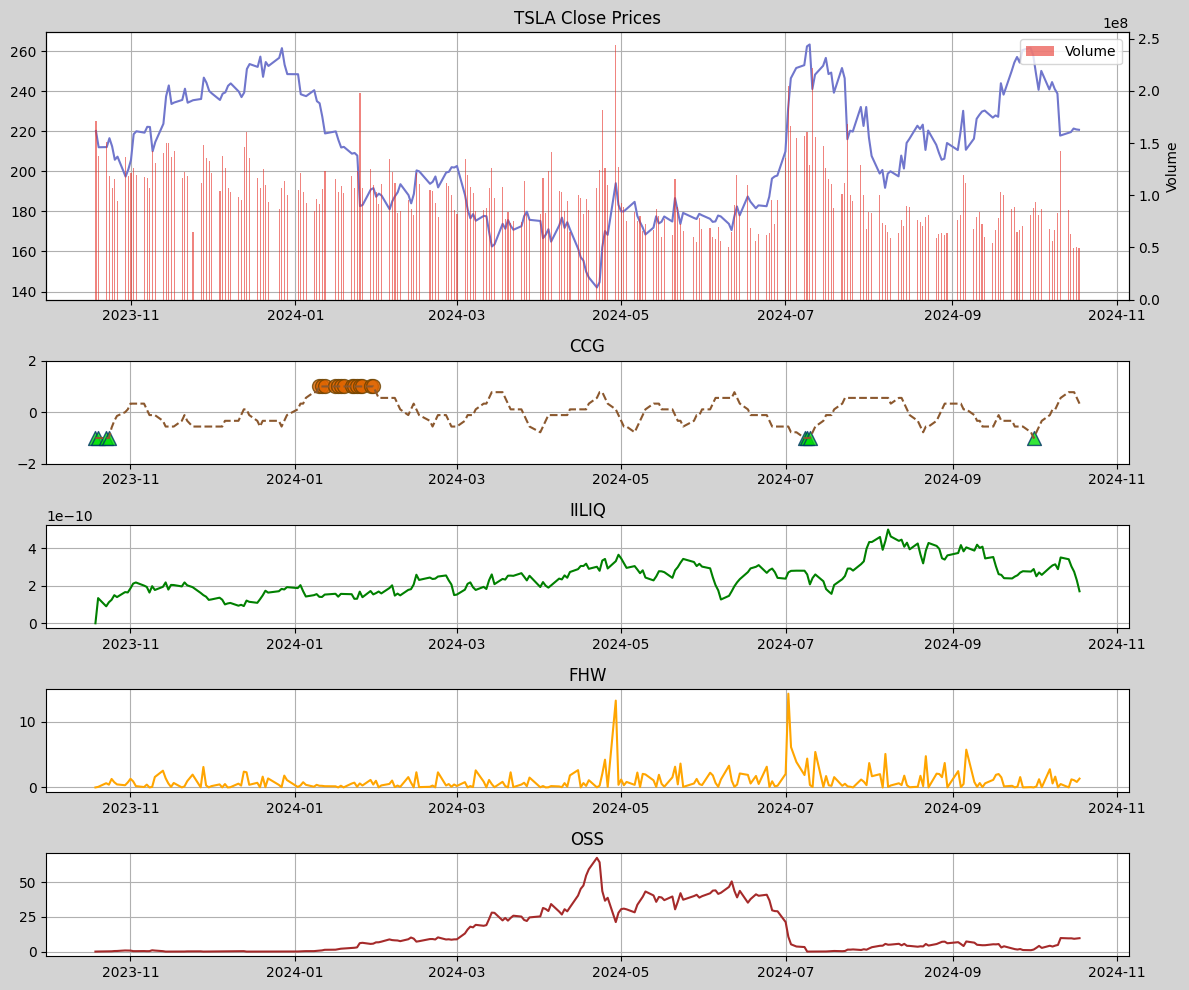

In [4]:
plt.figure(figsize=(12, 10), facecolor='lightgrey')

plt.subplot(6, 1, (1, 2))  # Double size by merging 3 rows
plt.plot(stock_data["Close"], c='#7076cc', lw=1.5)
plt.title(f'{CODE} Close Prices')
plt.grid()

ax2 = plt.gca().twinx()
ax2.bar(stock_data.index, stock_data["Volume"], alpha=0.6, color='#e6332a', width=0.4, label='Volume')
ax2.set_ylabel('Volume')
ax2.legend(loc='upper right')


# CCG Module
plt.subplot(6, 1, 3)
plt.scatter(stock_data.index[stock_data["CCG"] > 0.9],
            stock_data["CCG"].values[stock_data["CCG"] > 0.9],
            s=100, alpha=0.8, c='#E06500', edgecolors='#6B4200')

plt.scatter(stock_data.index[stock_data["CCG"] < -0.9],
            stock_data["CCG"].values[stock_data["CCG"] < -0.9],
            s=100, alpha=0.8, c='#00E005', marker='^', edgecolors='#003366')

plt.plot(stock_data['CCG'], c='#8B582E', ls='--')
plt.ylim([-2, 2])
plt.grid()
plt.title('CCG')


# plt.subplot(6, 1, 4)
# plt.plot(stock_data["STR"], c='g')
# plt.grid()
# plt.title('STR')

# Third subplot
plt.subplot(6, 1, 4)
stock_data["IILIQ"] = ILLIQ_Factor(stock_data, 9)
plt.plot(stock_data["IILIQ"], c='g')
plt.grid()
plt.title('IILIQ')

# Fourth subplot
plt.subplot(6, 1, 5)
plt.plot(stock_data["FHW"], c='orange')
plt.grid()
plt.title('FHW')

plt.subplot(6, 1, 6)
plt.plot(stock_data["OSS"], c='brown')
plt.grid()
plt.title('OSS')

plt.tight_layout()


In [36]:
from sklearn.preprocessing import StandardScaler, minmax_scale


def Creat_Sequence(stock_data, feature_list, seq_length=5, predict_length=7):
    sequences = []
    labels = []

    df = stock_data.copy()
    label_seies = df['Label'].shift(predict_length).fillna(0).copy()

    for i in range(len(df) - seq_length - predict_length):
        sequence = df[feature_list].iloc[i:i+seq_length, :].values.tolist()
        label = label_seies.iloc[i+seq_length]
        sequences.append(sequence)
        labels.append(label)

    # Convert sequences and labels to NumPy arrays
    sequences = np.array(sequences)  
    labels = np.array(labels)

    return sequences, labels


seq_length = 21
predict_length = 7
feature_list = ['High', 'Low', 'Open', 'Close']



# scale the input features to enhance robustness
saved_label = minmax_scale(stock_data['Close'].copy())
scaler = StandardScaler()
stock_data.fillna(0, inplace=True)
scaler.fit(stock_data[feature_list])
stock_data[feature_list] = scaler.transform(stock_data[feature_list])

stock_data['Label'] = saved_label
sequences, labels = Creat_Sequence(
                        stock_data, 
                        feature_list, 
                        seq_length=seq_length, 
                        predict_length=predict_length)


In [ ]:
from KSL_system import KumaModel
import torch
import joblib

reg_model = KumaModel(
            model_name='gru', 
            input_size=len(feature_list),
            hidden_size=32,
            output_size=1,
            num_layers=1,
            dropout_rate=0.2)

reg_model.set_train_params(loss_type='ic')
reg_model.train_model(sequences, y=labels, seq_length=seq_length, epochs=2000)

# torch.save(reg_model.model.state_dict(), 'kuma_models/my_model.pth')

# joblib.dump(scaler, 'kuma_models/scaler.gz')


In [ ]:

from sklearn.preprocessing import minmax_scale
def buying_index(reg_model, X_for_predict, predict_length):
  """
  This function predicts future closing prices and identifies potential buying opportunities.

  Args:
      reg_model: Trained regression model (GRUModel in your case)
      X_for_predict: A list or NumPy array containing the input sequence for prediction.
      predict_length: The number of days to predict into the future.

  Returns:
      None (Displays a plot with past and predicted closing prices and a potential buying index).
  """

  # Convert input to PyTorch tensor
  X_tensor = torch.tensor(X_for_predict, dtype=torch.float)

  # Predict closing prices
  y_predict = reg_model.model(X_tensor)
  y_predict_numpy = y_predict.detach().numpy()

  y_scaled = minmax_scale(y_predict_numpy)

  # Separate past and predicted prices
  past_prices = y_scaled[-2*predict_length:-predict_length]
  future_prices = y_scaled[-predict_length:]

  return y_scaled, past_prices, future_prices


y_scaled, past_prices, future_prices = buying_index(reg_model, sequences, predict_length)



plt.figure(figsize=(10, 4))
plt.scatter(range(predict_length), past_prices, 
            color='yellow', s=100, label=f'past {predict_length} days', edgecolors='black')
plt.scatter(range(predict_length, 2*predict_length), future_prices, alpha=0.7,
            color='blue', s=100, label=f'future {predict_length} days', edgecolors='black')
plt.plot(y_scaled[-2*predict_length:], lw=1.2, ls='--', alpha=0.7, c='purple')
trend_line = pd.DataFrame(y_scaled)[-2*predict_length:].rolling(3, 1).mean().values
plt.plot(trend_line, c='r', alpha=0.5, label='trend line')
x_ticks = np.arange(-predict_length, predict_length + 1)
x_labels = [f"T{(i if i == 0 else ('+' if i > 0 else '-') + str(abs(i)))}" for i in x_ticks]


plt.xticks(ticks=np.arange(2 * predict_length + 1), labels=x_labels)

plt.legend(loc='upper left')
plt.show()